# Modular carrier geometry

# Purpose
Make a more thurough analysis of the Modular carrier geometry

# Methodology
Load offset points from RHINO

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.99, 
                             exclude_table_name='rolldecay_exclude')

In [3]:
mask = df_rolldecay.BKL == 0
df = df_rolldecay.loc[mask].copy()

df_speed_variations = df.groupby(by = 'loading_condition_id').filter(lambda x: len(x['ship_speed'].unique()) > 1)
loading_conditions = df_speed_variations.groupby(by = 'loading_condition_id').first()
#loading_conditions

In [4]:
loading_condition = loading_conditions.loc[134]

In [5]:
loading_condition.TA

7.5

In [6]:
loading_condition.TF

7.5

In [7]:
loading_condition.lpp

193.8

In [8]:
draught = (loading_condition.TA + loading_condition.TF)/2

In [9]:
file_path = r'S:\2020\40209514-DEMOPS\03_Project\020_PROJECT_MANAGEMENT\arbetsmapp\ISOPE\points3d.txt'
points = pd.read_csv(file_path, sep=';', header=None)
points.columns = ['x','y','z']
points.describe()

,x,y,z
count,20717.000000,2.071700e+04,20717.000000
mean,80.594084,1.318084e+01,3.348210
std,68.325128,7.027157e+00,3.624176
min,-4.795000,-6.895055e-08,-0.003182
25%,23.041486,7.395656e+00,0.414801
50%,43.918851,1.268134e+01,2.206803
75%,159.624595,2.050386e+01,5.384788
max,201.505000,2.150280e+01,20.500002


In [10]:
ns = np.arange(10)
n_sections = []
for n in ns:
    n_sections.append( len(points['x'].round(decimals=n).unique()))

fig,ax=plt.subplots()
ax.plot(ns,n_sections)

<IPython.core.display.Javascript object>

In [11]:
points['x'] = points['x'].round(decimals=6)
points['z'] = points['z'].round(decimals=2)
x = points['x'].unique()
x_groups = points.groupby(by='x')
points2 = x_groups.filter(lambda x:x['x'].count() > 2)
x = points2['x'].unique()
x_groups = points2.groupby(by='x')

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(points['x'], points['y'], points['z'], '.')

<IPython.core.display.Javascript object>

In [13]:

N = 100
z_ = np.linspace(0,1,N)**-1.1
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)


section = x_groups.get_group(x[int(len(x)/2)])
section.sort_values(by='z', inplace=True)
y = np.interp(z, section['z'], section['y'])
    

fig,ax=plt.subplots()
section.plot(x='y', y='z', ax=ax)
ax.plot(y,z,'.:')

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

In [14]:
data = {
    'y':[3,2,1],
    'z':[5,3,2],
}
section = pd.DataFrame(data=data)

fig,ax=plt.subplots()
section.plot(x='y', y='z', style = 'ko-', label='original', ax=ax)

xy = section[['y','z']].values.tolist()


if xy[-1][0] > 0:
    centre_end_point = [0,xy[-1][1]]
    xy.append(centre_end_point)  # Adding missing centre end point

if xy[0][1] < draught:
    water_line_point_1 = [xy[0][0],draught]
    xy.insert(0,water_line_point_1)  # Adding missing water line point

top_centre_point = [0,xy[0][1]]
xy.insert(0,top_centre_point)

close_point = xy[-1]
xy.insert(0,close_point)
xy = np.array(xy)

ax.plot(xy[:,0], xy[:,1],'--')
ax.plot(*centre_end_point, 'ro', label='centre end point')
ax.plot(*water_line_point_1, 'bo', label='water_line_point_1')
ax.plot(*top_centre_point, 'yo', label='top_centre_point')
ax.plot(*close_point, 'ro', label='close_point')

ax.legend()



<IPython.core.display.Javascript object>

In [15]:
def close_section(section):
         
    """
    The sections are defined as:
    (y,z):
            0
            1
            2
            3
           4
    5
    """
    xy = section[['y','z']].values.tolist()

    if xy[-1][0] > 0:
        centre_end_point = [0,xy[-1][1]]
        xy.append(centre_end_point)  # Adding missing centre end point
    
    if xy[0][1] < draught:
        water_line_point_1 = [xy[0][0],draught]
        xy.insert(0,water_line_point_1)  # Adding missing water line point
    
    top_centre_point = [0,xy[0][1]]
    xy.insert(0,top_centre_point)
    
    close_point = xy[-1]
    xy.insert(0,close_point)
    xy = np.array(xy)
    
    closed_section = pd.DataFrame()
    closed_section['y'] = xy[:,0]
    closed_section['z'] = xy[:,1]
    closed_section['x'] = section.iloc[0].x
        
    return closed_section
    

In [16]:
x_groups = points.groupby(by='x')
N = 100
z_ = np.linspace(0,1,N)**-1.1
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)

df_sections = pd.DataFrame()

for i,(x_, section) in enumerate(x_groups):
    #section.sort_values(by='z', inplace=True)
    mask = section['z'] <= draught   
    section = section.loc[mask]
    if len(section)==0:
        continue
    
    new_section = pd.DataFrame()
    new_section['y']=section['y']
    new_section['x']=x_
    new_section['z']=section['z']
    new_closed_section = close_section(new_section)
    new_closed_section['no']=i
    df_sections = df_sections.append(new_closed_section)
    

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df_sections.head()

,y,z,x,no
0,-4.561995e-08,7.48,0.772297,4
1,0.000000e+00,7.50,0.772297,4
2,2.100311e+00,7.50,0.772297,4
3,1.800492e+00,7.50,0.772297,4
4,1.650543e+00,7.49,0.772297,4


In [18]:
def poly_area(xy):
    """ 
        Calculates polygon area using Greens formula.
        x = xy[:,0], y = xy[:,1]
    """
    xy1 = np.roll(xy,-1,axis = 0) # shift by -1
    return -0.5*np.inner(xy1[:,0] - xy[:,0],xy1[:,1] + xy[:,1])

def section_area(section):
    xy = section[['y','z']].values
    return np.abs(poly_area(xy=xy))

In [19]:
df_sections['x'].unique()

array([  0.772297,   2.164122,   3.555946,   4.94777 ,   6.339595,
         7.731419,   9.123243,  10.515068,  11.906892,  13.298716,
        14.690541,  16.082365,  17.474189,  18.866014,  20.257838,
        21.649662,  23.041486,  24.433311,  25.825135,  27.216959,
        28.608784,  30.000608,  31.392432,  32.784257,  34.176081,
        35.567905,  36.95973 ,  38.351554,  39.743378,  41.135203,
        42.527027,  43.918851,  45.310676,  46.7025  ,  48.094324,
        49.486149,  50.877973,  52.269797,  53.661622,  55.053446,
        56.44527 ,  57.837095,  59.228919,  60.620743,  62.012568,
        63.404392,  64.796216,  66.188041,  67.579865,  68.971689,
        70.363514,  71.755338,  73.147162,  74.538986,  75.930811,
        77.322635,  78.714459,  80.106284,  81.498108,  82.889932,
        84.281757,  85.673581,  87.065405,  88.45723 ,  89.849054,
        91.240878,  92.632703,  94.024527,  95.416351,  96.808176,
        98.2     ,  99.596014, 100.992027, 102.388041, 103.784

<IPython.core.display.Javascript object>


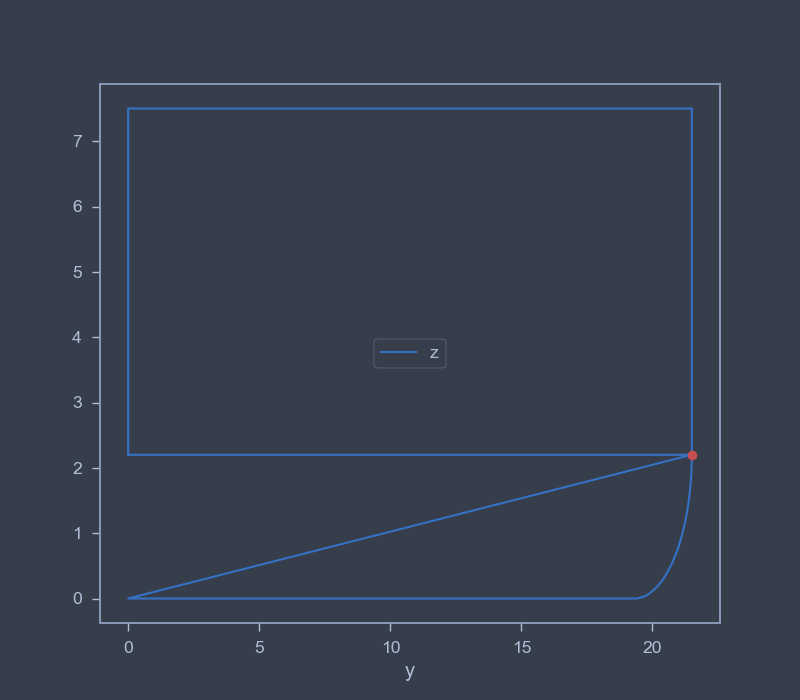

In [21]:
sections = df_sections.groupby(by='x')
section = sections.get_group(144.268446)
fig,ax=plt.subplots()
section.plot(x='y', y='z',ax=ax)
point = section.iloc[-2]
ax.plot(point['y'], point['z'],'ro')

In [22]:
point

y      21.500001
z       2.200000
x     144.268446
no    107.000000
Name: 90, dtype: float64

In [23]:
mask = ((df_sections['x'] == point.x) & (df_sections['y'] == point.y) & (df_sections['z'] == point.z))
df_sections=df_sections.loc[~mask]

<IPython.core.display.Javascript object>


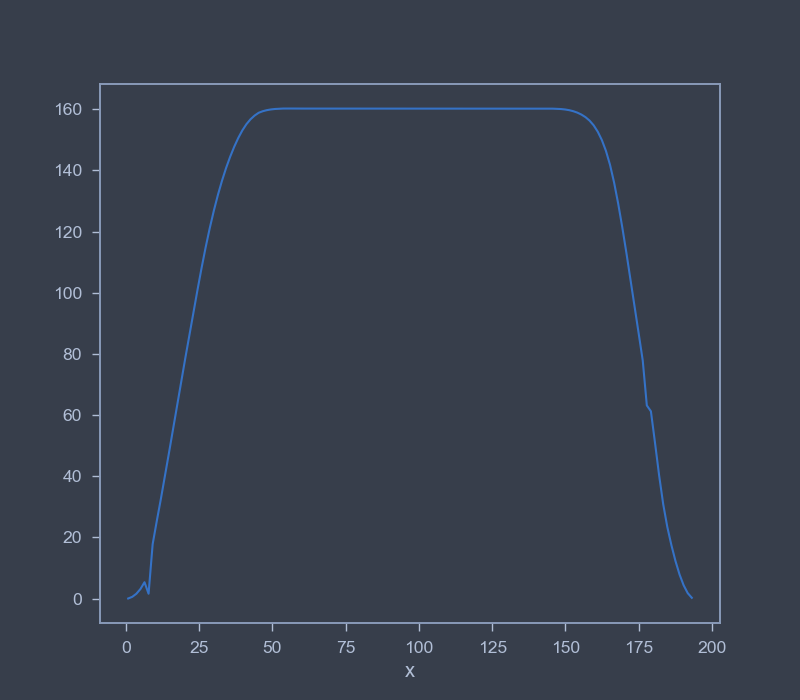

<AxesSubplot:xlabel='x'>

In [24]:
sections = df_sections.groupby(by='x')
areas = sections.apply(func=section_area)
fig,ax=plt.subplots()
areas.plot(ax=ax)

In [25]:
min_area = 1
df_sections2 = sections.filter(func=lambda x : section_area(x) > min_area)
sections = df_sections2.groupby(by='x')

<IPython.core.display.Javascript object>


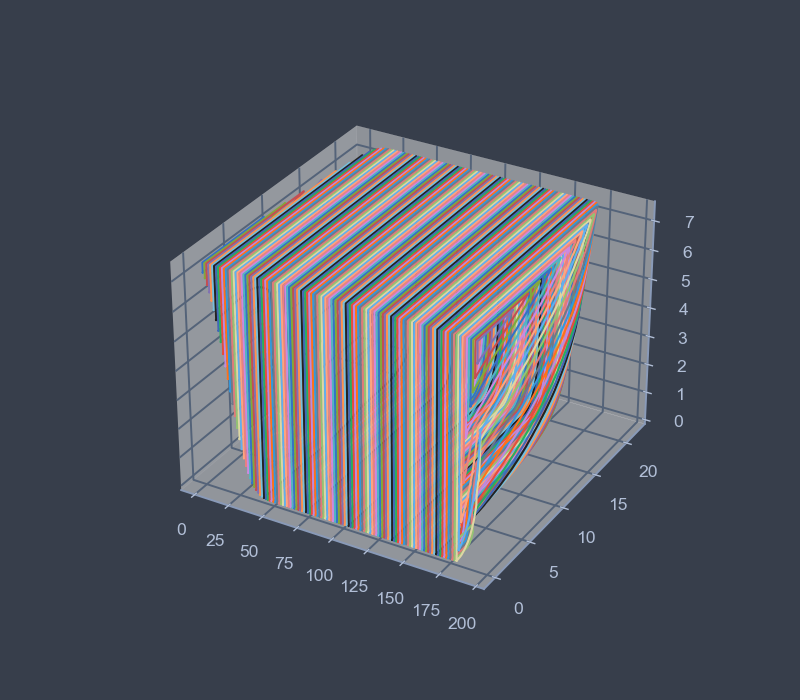

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for no,section, in sections:
    
    ax.plot(section['x'], section['y'], section['z'])

In [27]:
x_interps = np.linspace(df_sections2['x'].min(), df_sections2['x'].max(),21)
xs = df_sections2['x'].unique()
x_ = []
for x_interp in x_interps:
    i = np.argmin(np.abs(x_interp - xs))
    x_.append(xs[i])
    
df_sections3 = pd.DataFrame()
for i,x in enumerate(x_):
    section = sections.get_group(x)
    section['no'] = i
    df_sections3 = df_sections3.append(section)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


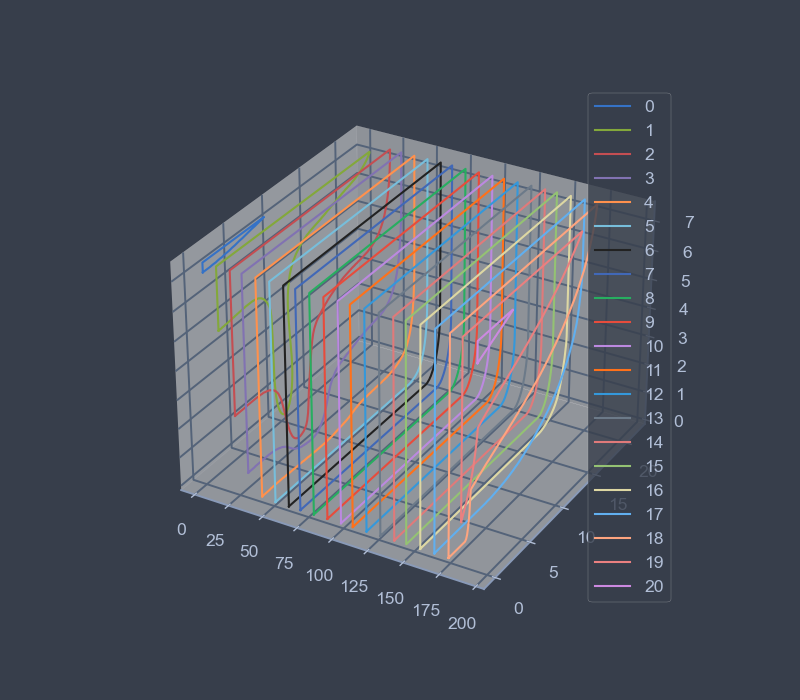

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sections2 = df_sections3.groupby(by='no')
for no, section in sections2:
    
    ax.plot(section['x'], section['y'], section['z'], label=no)
    
ax.legend()

<IPython.core.display.Javascript object>


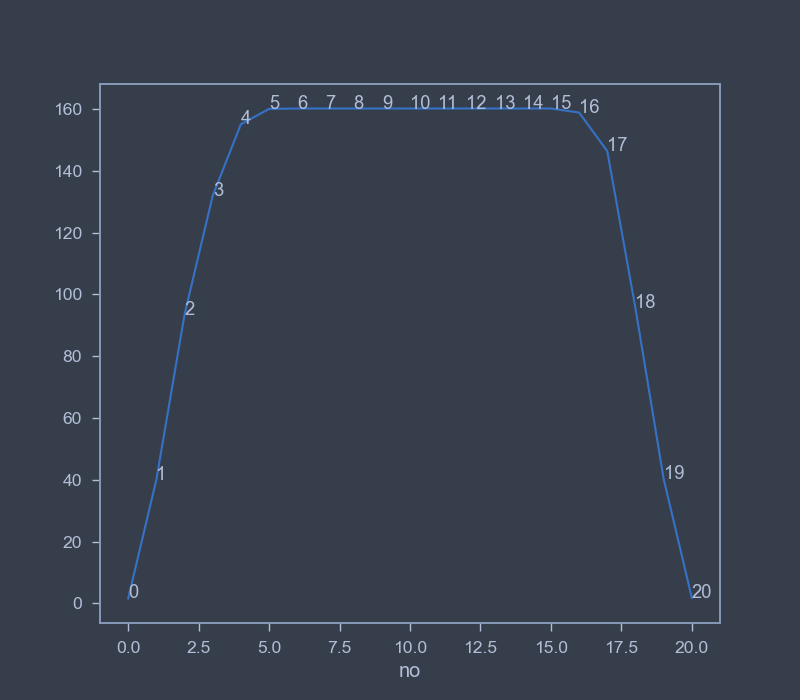

In [29]:
areas2 = sections2.apply(section_area)
fig,ax=plt.subplots()
areas2.plot(ax=ax)
for no,a in areas2.items():
    ax.annotate(no,xy=(no,a))

In [31]:
def estimate_bilge_radius(section):
    b = section['b']  
    t = section['t']
    A = section['area']  
    r = np.sqrt(4/np.pi*(b*t-A))
    return r

def section_data(section):
    
    s = pd.Series()
    s.name=section.name
    s['area'] = 2*section_area(section) # two sides
    s['x'] = section.iloc[0].x
    s['t'] = section.z.max() - section.z.min()
    s['b'] = 2*section.y.max()  # two sides
    s['r_b'] = estimate_bilge_radius(s)
    
    return s
    

In [32]:
df_section_properties = sections2.apply(func=section_data)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [33]:
df_section_properties.to_csv('../data/interim/volume_carrier_areas.csv', sep=';')

In [34]:
df_section_properties

,area,x,t,b,r_b
no,,,,,
0,3.152037,3.555946,0.32,15.590334,1.529306
1,80.056100,13.298716,6.77,40.829136,15.811695
2,186.996780,23.041486,7.50,42.999309,13.134742
3,263.957911,31.392432,7.50,43.000004,8.633547
4,310.254925,41.135203,7.50,43.000004,3.948538
5,320.160691,50.877973,7.50,43.000004,1.725844
6,320.419782,60.620743,7.50,43.000004,1.627468
7,320.419782,68.971689,7.50,43.000004,1.627468
8,320.419782,78.714459,7.50,43.000004,1.627468
